In [1]:
import logging
import os
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import requests
import tensorflow as tf
import tensorflow.keras as keras
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define base directory
base_dir = "/kaggle/input/paddy-disease-classification"

# Define train, test, and valid directories
train_dir = os.path.join(base_dir, "train_images")
test_dir = os.path.join(base_dir, "test_images")
validation_dir = os.path.join(base_dir, "train_images")

# Image Preprocessing
# Validation Data Generator
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    train_dir,
    shuffle=False,
    validation_split=0.2,
    seed=42,
    color_mode="rgb",
    class_mode="categorical",
    target_size=(224, 224),  # Adjust as needed
    batch_size=10)  # Adjust batch size as needed

# Train Data Generator with Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)
    

train_generator = train_datagen.flow_from_directory(
    train_dir,
    subset="training",
    shuffle=True,
    seed=42,
    color_mode="rgb",
    class_mode="categorical",
    target_size=(224, 224),  # Adjust as needed
    batch_size=10)  # Adjust batch size as needed

# Test Data Generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    shuffle=False,
    seed=42,
    color_mode="rgb",
    class_mode="categorical",
    target_size=(224, 224),  # Adjust as needed
    batch_size=10)  # Adjust batch size as needed


In [ ]:
# Define classes
classes = ['blast','blight','healthy','spot','tungro']

# Define function to display sample images
def display_sample_images(directory, classes, num_images=3, image_size=(100, 100)):
    for disease in classes:
        # Get path for current disease
        disease_path = os.path.join(directory, disease)

        # Get list of images for current disease
        image_files = os.listdir(disease_path)

        # Randomly select num_images images
        selected_images = np.random.choice(image_files, num_images, replace=False)

        # Display the selected images
        fig, axes = plt.subplots(1, num_images, figsize=(10, 5))
        fig.suptitle(f'Sample Images for {disease} Category', fontsize=20)

        for i, image_name in enumerate(selected_images):
            image_path = os.path.join(disease_path, image_name)
            img = Image.open(image_path)
            img = img.resize(image_size)  # Resize image
            axes[i].imshow(img)
            axes[i].set_title(image_name, fontsize=12)
            axes[i].axis('off')

        plt.show()

# Display sample images for each disease category in the training directory
display_sample_images(train_dir, classes, image_size=(200, 200))

### MobileNetV2


9406464/9406464 [==============================] - 0s 0us/step

Epoch 1/10

520/520 [==============================] - 2228s 4s/step - loss: 0.5546 - accuracy: 0.7912 - val_loss: 0.2936 - val_accuracy: 0.8791

Epoch 2/10

520/520 [==============================] - 203s 391ms/step - loss: 0.3185 - accuracy: 0.8759 - val_loss: 0.2929 - val_accuracy: 0.8832

Epoch 3/10

520/520 [==============================] - 198s 381ms/step - loss: 0.2640 - accuracy: 0.9024 - val_loss: 0.1909 - val_accuracy: 0.9334

Epoch 4/10

520/520 [==============================] - 199s 383ms/step - loss: 0.2291 - accuracy: 0.9146 - val_loss: 0.1590 - val_accuracy: 0.9348

Epoch 5/10

520/520 [==============================] - 194s 373ms/step - loss: 0.1965 - accuracy: 0.9217 - val_loss: 0.1446 - val_accuracy: 0.9457

Epoch 6/10

520/520 [==============================] - 201s 387ms/step - loss: 0.2078 - accuracy: 0.9205 - val_loss: 0.1325 - val_accuracy: 0.9511

Epoch 7/10

520/520 [============================

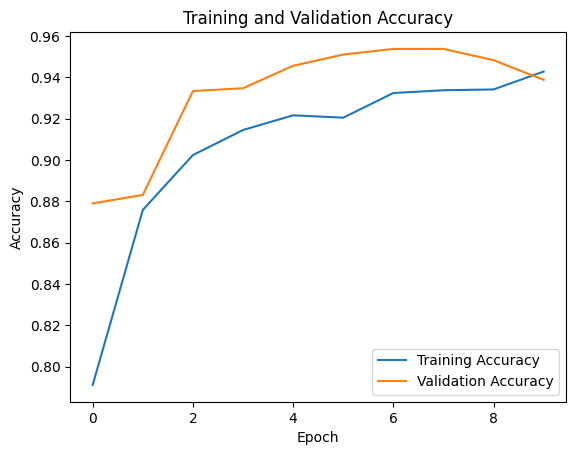

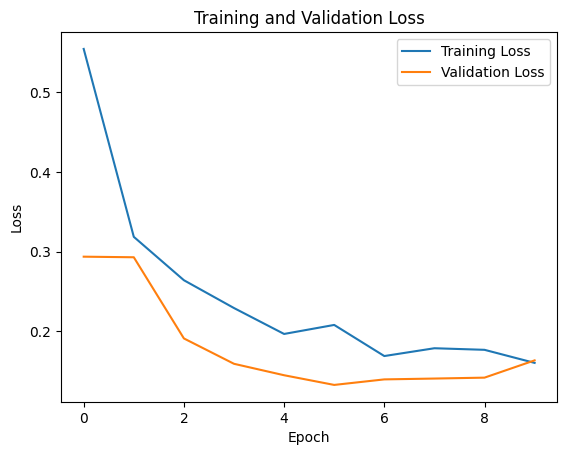

150/150 [==============================] - 542s 4s/step - loss: 0.1453 - accuracy: 0.9424



Test accuracy: 94.24363970756531

Test loss: 0.14531072974205017


In [5]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2

# Train Model
mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in mobilenet_base.layers:
    layer.trainable = False

model = tf.keras.Sequential([
    mobilenet_base,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')  # Adjusted for five classes
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print()
print(f'Test accuracy: {test_accuracy*100}')
print(f'Test loss: {test_loss}')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Save the model to Google Drive
model.save('/content/drive/MyDrive/model/paddy_disease_mobilenet_model.h5')


# Predict classes for test data
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes
true_classes = test_generator.classes

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['blast','blight','healthy','spot','tungro'], yticklabels=['blast','blight','healthy','spot','tungro'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
